## 1. 작업환경 구성

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline



## 2. 데이터셋 구성

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [3]:
train_x.max()

255

In [4]:
train_x.min()

0

In [5]:
# -1 ~ +1 사이의 값으로정규화
train_x = (train_x - 127.5) / 127.5
print(train_x.max())
print(train_x.min())

1.0
-1.0


In [6]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


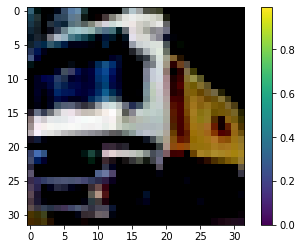

In [7]:
# 시각화
plt.imshow(train_x[1])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


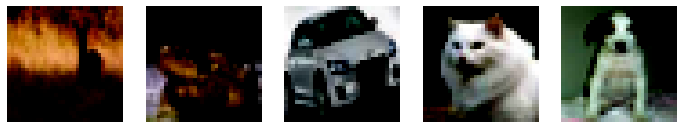

In [8]:
#랜덤으로 5개 시각화
plt.figure(figsize=(12, 12))

for i in range(5):
    plt.subplot(1,5,i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.axis('off')

plt.show()

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 3. 생성자 모델 구현

In [88]:
def make_generator_model():


    model = tf.keras.Sequential()

    #Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape layer : Conv layer에 들어가기 전에 3차원으로 다시 구성
    model.add(layers.Reshape((8, 8, 256)))

    #Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [89]:
generator = make_generator_model()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_12 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)        

In [90]:
noise = tf.random.normal([1, 100]) #tf.random.normal 가우시안 분포에서 뽑아낸 랜덤 벡터 생성

In [91]:
# 랜덤 벡터를 생성자에 넣어보자
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

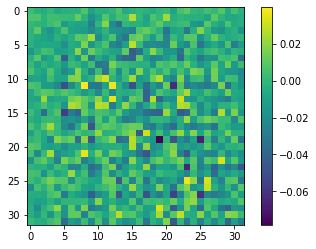

In [92]:
# 랜덤벡터 > 생성자 모델로 출력된 이미지 시각화
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## 4 . 판별자 모델 구현

In [93]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1)) #최종 출력은 하나의 숫자가 나와야함

    return model

In [94]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [95]:
#이전의 랜덤벡터로 생성했던 이미지를 판별자 모델에 넣어보자
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00145809]], dtype=float32)>

## 5. 손실함수

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # 마지막 값을 0~1 로

In [16]:
#generator_loss
#fake_output - 1 사이의 손실
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
#discriminator_loss
#real_output - 1 사이, fake_output - 0 사이 손실
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
#discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy


In [19]:
#optimizer , 생성자와 판별자는 각각 학습을 진행하기 때문에 따로 정의해줘야 함
# learning rate = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
# 샘플을 만들어 학습과정 확인
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [21]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [22]:
# 샘플을 생성하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [23]:
# loss, accuracy 시각화 함수
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
 
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [24]:
#check point 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
#훈련 함수
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [26]:
save_every = 10
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

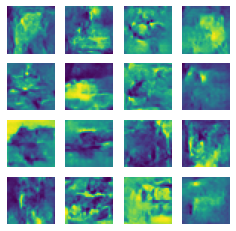

Time for training : 8442 sec


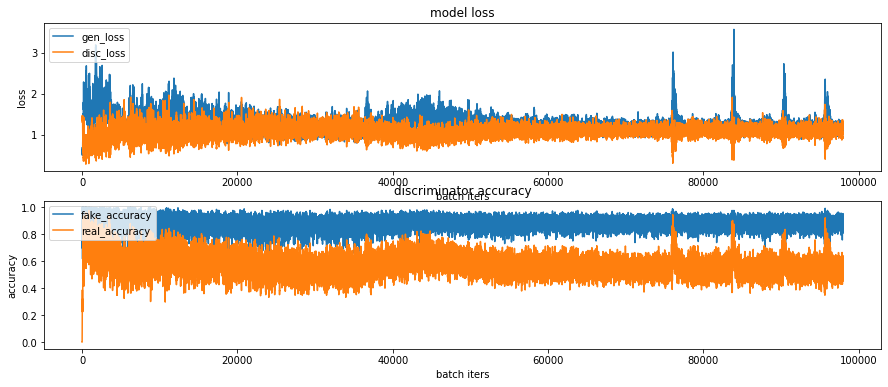

CPU times: user 2h 24min 14s, sys: 13min 17s, total: 2h 37min 31s
Wall time: 2h 20min 47s


In [108]:
%%time
train(train_dataset, EPOCHS, save_every)

fake acc 가 아직 1 근방에서 머무는 걸로 보아, 제대로 그림이 생성되지 않았음을 알 수 있다. 
epoch 가 500으로 꽤 많이 훈련시켰는데 이러한 결과가 나온것을 보아, 모델의 파라미터 수를 늘려서 더 복잡한 모델로 만들어보자.

In [11]:
#생성자 모델 수정
def make_generator_model():


    model = tf.keras.Sequential()

    #Dense layer
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape layer : Conv layer에 들어가기 전에 3차원으로 다시 구성
    model.add(layers.Reshape((8, 8, 512)))

    #Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [12]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [123]:
#판별자 모델 수정
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #  Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten Layer
    model.add(layers.Flatten())

    #  Dense Layer
    model.add(layers.Dense(8))
    model.add(layers.Dense(1)) #최종 출력은 하나의 숫자가 나와야함

    return model

In [124]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 128)       

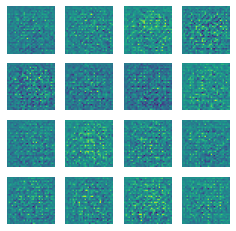

Time for training : 8484 sec


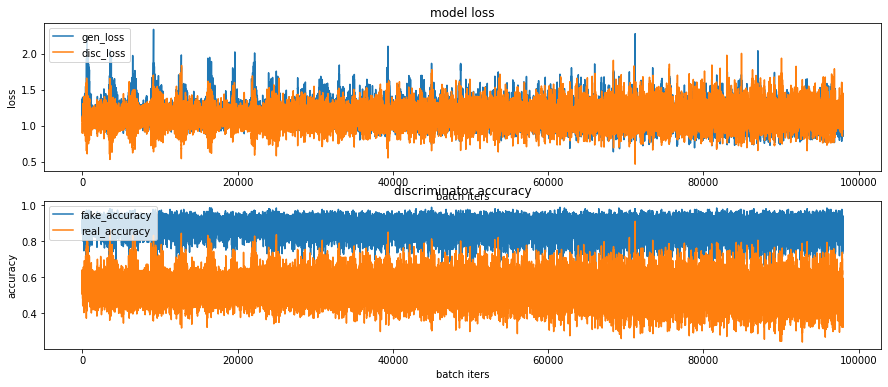

CPU times: user 2h 25min 7s, sys: 13min 19s, total: 2h 38min 27s
Wall time: 2h 21min 30s


In [125]:
%%time
train(train_dataset, EPOCHS, save_every)

생성자와 판별자의 복잡도 모두 를 높였더니 오히려 더욱 이상한 그림을 생성해 내었다. 
이번에는 생성자의 복잡도만 높이고 판별자의 복잡도는 맨 처음과과 같이 유지해보자.

In [13]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1)) #최종 출력은 하나의 숫자가 나와야함

    return model

In [14]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [27]:
EPOCHS = 100

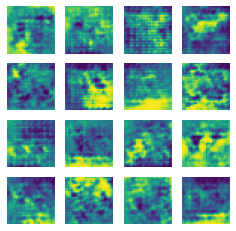

Time for training : 1672 sec


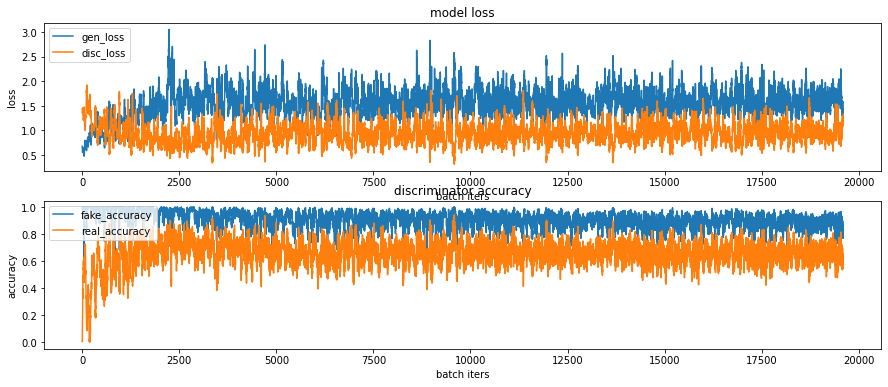

CPU times: user 28min 38s, sys: 2min 39s, total: 31min 18s
Wall time: 27min 53s


In [28]:

%%time
train(train_dataset, EPOCHS, save_every)

epoch를 100회만 진행하였음에도 전 모델보다 조금 더 선명한 그림을 생성하였다.
epoch를 늘려 생성을 더 진행해보자.